In [1]:
############# Plotting cell
%matplotlib inline

import matplotlib.pylab as plt



# We are going to investigate the need for more/less iteration during training

This investigation was lead on the FCN16 architecture.

We will investigate this in two steps. 
- First by looking at the loss function and accuracy function over training.
- Followed by randomly picking images to see the effect on real data


All the path and net loading we need:

In [2]:
import sys
#sys.path.append('/home/naylor/Documents/Python/PhD/PhD_Fabien/')
sys.path.append('/data/users/pnaylor/Documents/Python/PhD_Fabien')
import os
import caffe
import numpy as np
import glob
import random
from skimage.io import imread as ir

caffe.set_mode_gpu()
number_images = 5

root_directory = "/home/naylor/Documents/Python/PhD/dataFCN/FCN16/"
root_directory = "/data/users/pnaylor/Documents/Python/FCN/FCN16/"
input_images = "/home/naylor/Documents/Python/PhD/dataFCN/RGB/"
input_images = "/data/users/pnaylor/Documents/RGB/"

snapshot_directory = os.path.join(root_directory, "snapshot")
final_weight = os.path.join(root_directory, "temp_files", "weights.pretrained.caffemodel")
model_def = os.path.join(root_directory, "deploy.prototxt")

loss_file = os.path.join(root_directory, "loss.npy")
acc_file = os.path.join(root_directory, "acc.npy")

weights_files = glob.glob( os.path.join(snapshot_directory, "snapshot_iter_*.caffemodel") )
image_files = glob.glob( os.path.join(input_images, "*.png") )
random.shuffle(image_files)
test_images = image_files[0:number_images]

In [3]:
model_def

'/data/users/pnaylor/Documents/Python/FCN/FCN16/deploy.prototxt'

## Plotting the loss function 

number of values on top of 200000: 10


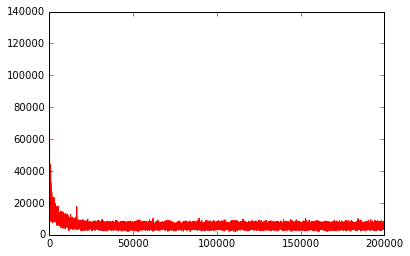

In [7]:
acc =  np.load(acc_file)
loss = np.load(loss_file)

print "number of values on top of 200000: {}".format(sum(loss > 200000))
loss[loss > 200000] = 100000
### thin out the loss function as it is highly variable

space = 10
new_loss = np.zeros(len(loss)/space)
new_acc = np.zeros(len(acc)/space)
for i in range(len(new_loss)):
    new_loss[i] = np.mean(loss[i*space:(i+1)*space])
    new_acc[i] = np.mean(acc[i*space:(i+1)*space])


iterations = range(0,len(loss), space)

plt.plot(iterations, new_loss, "-r")
plt.show()

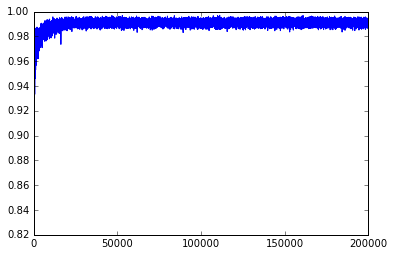

In [8]:
plt.plot(iterations, new_acc, "-b")
plt.show()

From these two graphs we can say that 50000 iterations seems way enough.

# Lets randomly pick 5 images for the folder file

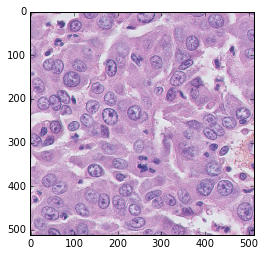

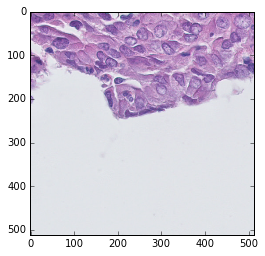

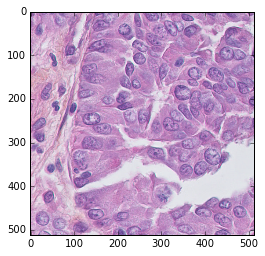

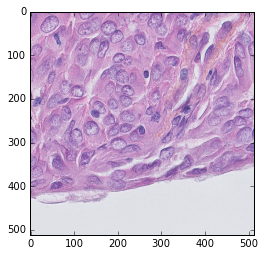

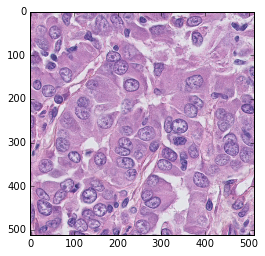

In [9]:
for image in test_images:
    img = ir(image)
    plt.figure()
    plt.imshow(img)

# Lets now setup the net given a weight file and images

In [10]:
## as caffe works with blobs...
## Setting image files
x, y, z = img.shape
image_array = np.zeros(shape=(len(test_images), x, y, z-1)) ## they have 4 dimensions
i = 0
for image in test_images:
    image_array[i,:,:,:] = ir(image)[:,:,0:3]
    i += 1

In [11]:
from CheckingSolvingState.OutputNet import Transformer, GetScoreVectors

def Net(weights, data_batch_size):
    net = caffe.Net(model_def,      # defines the structure of the model
                    weights,  # contains the trained weights
                    caffe.TEST) 
    net.blobs['data'].reshape(data_batch_size, 3, 512, 512)
    return net

def Out(loss_image):
    classed = np.argmax(loss_image, axis=0)

    names = dict()
    all_labels = ["0: Background"] + ["1: Cell"]
    scores = np.unique(classed)
    labels = [all_labels[s] for s in scores]
    num_scores = len(scores)

    def rescore(c):
        """ rescore values from original score values (0-59) to values ranging from 0 to num_scores-1 """
        return np.where(scores == c)[0][0]
    rescore = np.vectorize(rescore)

    painted = rescore(classed)
    return painted

def All(weight_file, image_array):
    net = Net(weights_files[-1], len(image_array))
    transformer = Transformer(net)
    score = GetScoreVectors(net, image_array, transformer, "score")
    pred_img = np.zeros(shape=(score.shape[0],score.shape[2],score.shape[3]))
    for i in range(score.shape[0]):
        pred_img[i,:,:] = Out(score[i,:,:,:])
    return pred_img

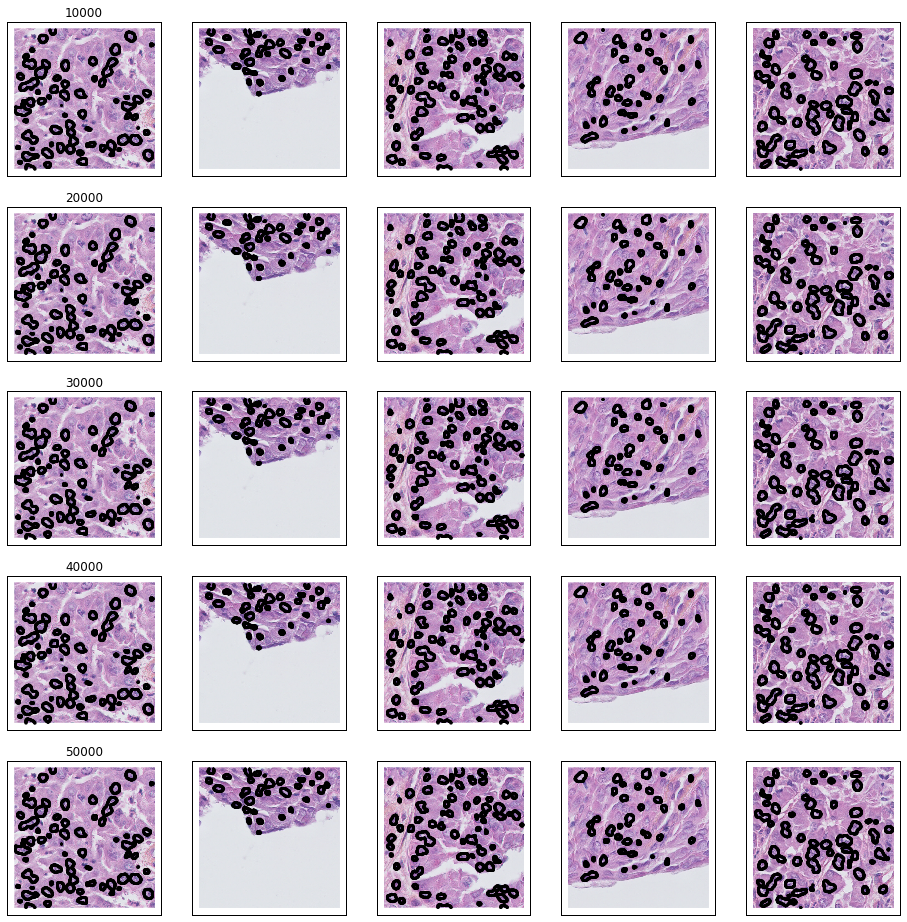

In [17]:
from UsefulFunctions.usefulPloting import Contours

snapshot_time = 10000
total = 50000
fig, axes = plt.subplots(5, 5, figsize=(16, 16),
                         subplot_kw={'xticks': [], 'yticks': []})

weights_files = glob.glob( os.path.join(snapshot_directory, "snapshot_iter_*.caffemodel") )
iter__ = range(snapshot_time, total+snapshot_time, snapshot_time)
for i in range(5):
    iter_ = iter__[i]
    w_file = os.path.join(snapshot_directory, "snapshot_iter_{}.caffemodel".format(iter_))
    t = All(w_file, image_array)    
    for j in range(5):
        ContourSegmentation = Contours(t[j,:,:])
        x_, y_ = np.where(ContourSegmentation.transpose() > 0)
        axes[i,j].imshow(ir(test_images[j]))
        axes[i,j].scatter(x=x_, y=y_, c='r', s=1)
        if j == 0:
            axes[i,j].set_title(str(iter_))

plt.show()